In [1]:
import os
import numpy as np
from numpy.linalg import svd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path as pth
from pyslingshot import Slingshot
import random
import anndata as ad
from sklearn.decomposition import PCA

/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set Working DirectorY

In [2]:
os.chdir(pth.home() / 'traj-alignment')

### Load Data

In [3]:

# set colnames
colnames =['Alcohol','Malic_acid','Ash','AlcalinitY_of_ash','Magnesium','Total_phenols','Flavanoids','Nonflavanoid_phenols','ProanthocYanins','Color_intensitY','Hue','OD280/OD315_of_diluted_wines','Proline']

colnames = [s.lower() for s in colnames]

wine = pd.read_csv(open('raw-data/wine.data', 'r'), delimiter = ',', index_col=None, names = colnames)

In [4]:
# wine_variety = wine.index.values-1
wine_variety = np.array(['x', 'y', 'z'])[wine.index.values-1]
wine_variety

In [5]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Split Data
Make two datasets from same original data. 
- Overlap between samples but not features
- Overlap between samples and features
- No overlap between samples but overlap between features
- No overlap between samples or features

In [6]:
# fiX index
wine.index = range(0,wine.shape[0],1)

# Datasets with no sample or feature overlap 
n = wine.shape[0]
p = wine.shape[1]
n_rw = n // 2  
n_col = p // 2  

random.seed(949)
rw_inds_a = random.sample(range(n), k=n_rw)
rw_inds_b = list(set(range(n)) - set(rw_inds_a))

a_variety = wine_variety[rw_inds_a]
b_variety = wine_variety[rw_inds_b]

col_inds_a = random.sample(range(p), k = n_col)
col_inds_b = list(set(range(p)) - set(col_inds_a))

In [7]:
a = wine.iloc[rw_inds_a, col_inds_a]
b = wine.iloc[rw_inds_b, col_inds_b]

#### Make AnnData

In [8]:
aobj = ad.AnnData(a)
bobj = ad.AnnData(b)

aobj.obs['variety'] = a_variety
bobj.obs['variety'] = b_variety

# aobj.cluster_labels=aobj.obs
# bobj.cluster_labels=bobj.obs

/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: X converted to numpy array with dtype float64
  return fn(*args_all, **kw)
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: X converted to numpy array with dtype float64
  return fn(*args_all, **kw)
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


### Scale data and calculate pcs

In [9]:
# 0 mean unit variance
standardize = lambda X:  X.sub(X.mean(axis=0), axis = 1).div(X.std(axis =0), axis = 1)

#PCs
def get_PCs(X):
    pcs = PCA( n_components = 4).fit_transform(X)
    pcs = pd.DataFrame(pcs)
    pcs.columns = [f"PC{i}" for i in range(pcs.shape[1])]
    return pcs

aobj.layers["scld"]= standardize(a)
bobj.layers["scld"]= standardize(b)

aPCS = get_PCs(aobj.layers["scld"])
aPCS.index = aobj.obs_names
aobj.obsm["PCA"]= np.asarray(aPCS)

bPCS = get_PCs(bobj.layers["scld"])
bPCS.index = bobj.obs_names
bobj.obsm["PCA"]= np.asarray(bPCS)

##### Plot PCS

In [10]:
print(aobj)
print(bobj)

AnnData object with n_obs × n_vars = 89 × 6
    obs: 'variety'
    obsm: 'PCA'
    layers: 'scld'
AnnData object with n_obs × n_vars = 89 × 7
    obs: 'variety'
    obsm: 'PCA'
    layers: 'scld'


/var/folders/37/ky9h5bb57_z53c6_yl5j5_580000gn/T/ipykernel_2254/1985508749.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Wine variety")


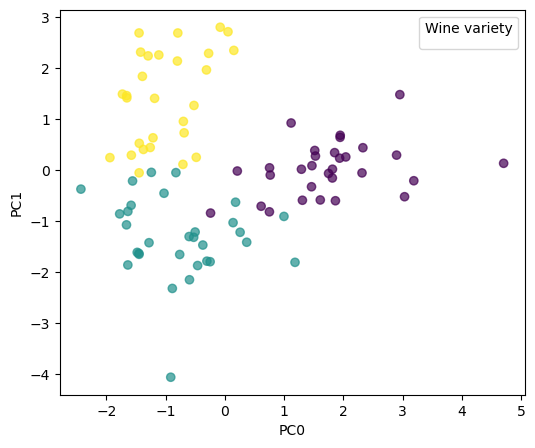

/var/folders/37/ky9h5bb57_z53c6_yl5j5_580000gn/T/ipykernel_2254/1985508749.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Wine variety")


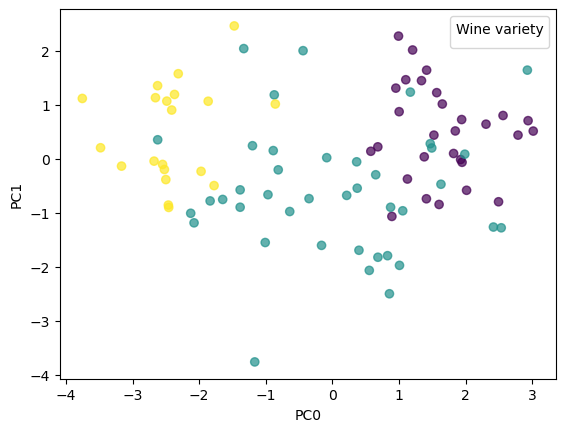

In [11]:
a = (
    pd.DataFrame(aobj.obsm['PCA'])
    .assign(source = 'a')
)
b = (
    pd.DataFrame(bobj.obsm['PCA'])
    .assign(source = 'b')
)

plot_df = pd.concat([a, b], axis=0, ignore_index=True)
plot_df["variety"] = np.concatenate([a_variety, b_variety])

plt.figure(figsize=(6, 5))

for s in plot_df["source"].unique():
    mask = plot_df["source"] == s
    plt.scatter(
        plot_df.loc[mask, 0],
        plot_df.loc[mask, 1],
        c=plot_df.loc[mask, "variety"].map({"x": 0, "y": 1, "z": 2}),
        alpha=0.7
    )
    plt.xlabel("PC0")
    plt.ylabel("PC1")
    plt.legend(title="Wine variety")
    plt.show()

### Calculate Trajectories

/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/util.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/util.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(cluster_labels[0], str):


Lineages: [Lineage[0, 1, 2]]


  0%|          | 0/5 [00:00<?, ?it/s]

Reversing from leaf to root
Reversing from leaf to root
Reversing from leaf to root
Reversing from leaf to root
Reversing from leaf to root
Lineages: [Lineage[0, 1, 2]]


/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:421: RuntimeWarning: invalid value encountered in divide
  cell_weights = weight_scores / np.nanmax(weight_scores, axis=1, keepdims=True)
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:537: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:421: RuntimeWarning: invalid value encountered in divide
  cell_weights = weight_scores / np.nanmax(weight_scores, axis=1, keepdims=True)
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/util.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

  0%|          | 0/5 [00:00<?, ?it/s]

Reversing from leaf to root

/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:421: RuntimeWarning: invalid value encountered in divide
  cell_weights = weight_scores / np.nanmax(weight_scores, axis=1, keepdims=True)
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:537: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/canderson/miniconda3/envs/traj-alignment/lib/python3.12/site-packages/pyslingshot/slingshot.py:421: RuntimeWarning: invalid value encountered in divide
  cell_weights = weight_scores / np.nanmax(weight_scores, axis=1, keepdims=True)



Reversing from leaf to root
Reversing from leaf to root
Reversing from leaf to root
Reversing from leaf to root


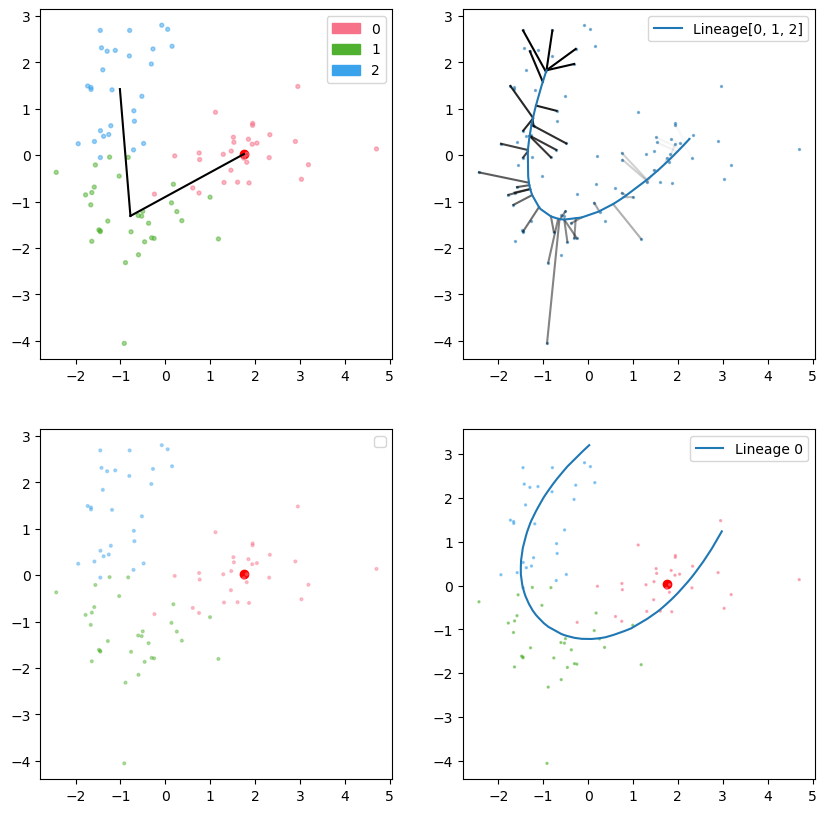

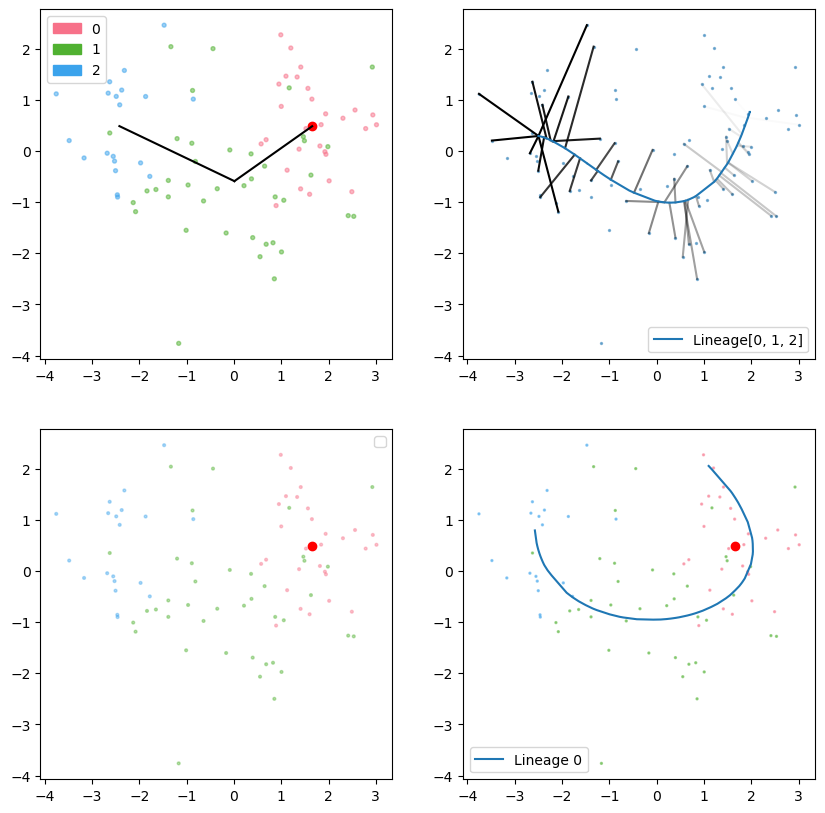

In [12]:

def get_sling(annData):
    random.seed(1030)
    slingshot = Slingshot(annData, 
                    celltype_key="variety", 
                    obsm_key="PCA", 
                    start_node=0, 
                    is_debugging="verbose", 
                    approx_points=100,
                    )
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    custom_Xlim = (-12, 12)
    custom_Ylim = (-12, 12)
    # plt.setp(axes, Xlim=custom_Xlim, Ylim=custom_Ylim)
    slingshot.fit(num_epochs=5, debug_axes=axes)
    
    return slingshot
    

aobj.uns['slingshot'] = get_sling(aobj)
bobj.uns['slingshot'] = get_sling(bobj)

In [13]:
# fig, aXes = plt.subplots(ncols=2, figsize=(12, 4))
# aXes[0].set_title("Clusters")
# aXes[1].set_title("Pseudotime")
# slingshot.plotter.curves(aXes[0], slingshot.curves)
# slingshot.plotter.clusters(aXes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
# slingshot.plotter.clusters(aXes[1], color_mode="pseudotime", s=5)

#### Extract curves as array

In [14]:
aobj.uns['curve'] = aobj.uns['slingshot'].curves[0].points
bobj.uns['curve'] = bobj.uns['slingshot'].curves[0].points

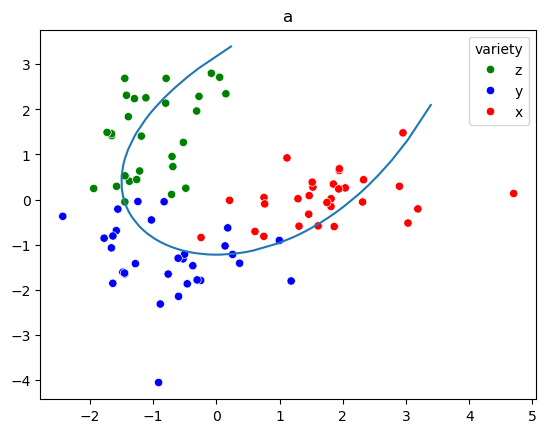

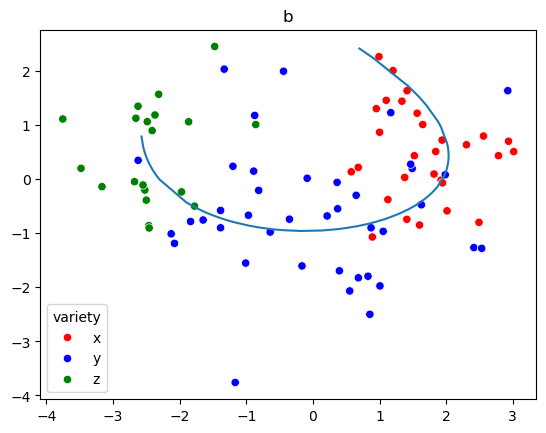

In [15]:

for obj,nm in zip([aobj, bobj],['a', 'b']):
    # plt.scatter(obj.obsm['PCA'][:,0], obj.obsm['PCA'][:,1], c = obj.obs["variety"].map({"x": "red","y": "blue","z": "green"}))
    sns.scatterplot(
        x=obj.obsm["PCA"][:,0],
        y=obj.obsm["PCA"][:,1],
        hue=obj.obs["variety"],
        palette={"x": "red","y": "blue","z": "green"}
    )
    plt.plot(obj.uns['curve'][:,0], obj.uns['curve'][:,1])
    plt.title(label = nm)
    plt.show()

### Orthogonal Procrustes alignment (map **Y → X**)

Given centered and scaled matrices
$$
X,\, Y \in \mathbb{R}^{n \times p},
\qquad
R \in \mathbb{R}^{p \times p},
$$
we estimate an orthogonal transformation that aligns **Y** to **X** by solving

$$
R^{*} = \arg\min_{R \in \mathbb{R}^{p \times p}} \| YR - X \|_{F}^{2}
\quad \text{subject to} \quad
R^{\top}R = I.
$$

Let the cross-covariance matrix be
$$
M = Y^{\top} X.
$$

If the singular value decomposition of \( M \) is
$$
M = U \Sigma V^{\top},
$$
then the optimal rotation matrix is given by
$$
R^{*} = U V^{\top}.
$$


### Procrustes

In [16]:
acurve = aobj.uns['curve']
bcurve = bobj.uns['curve']

print(acurve.shape)
print(bcurve.shape)

(87, 4)
(82, 4)


##### Resample curves so dims match

In [17]:
T = min(acurve.shape[0], bcurve.shape[0])


def resample_curve(curve, T):
    """
    curve: (n_points, p)
    returns: (T, p)
    """
    # cumulative arc length
    diffs = np.diff(curve, axis=0)
    seglen = np.linalg.norm(diffs, axis=1)
    s = np.concatenate([[0], np.cumsum(seglen)])

    # normalize to [0, 1]
    s /= s[-1]

    # target positions
    s_new = np.linspace(0, 1, T)

    # interpolate each dimension
    return np.vstack([
        np.interp(s_new, s, curve[:, d])
        for d in range(curve.shape[1])
    ]).T

acurve_new = resample_curve(acurve, T)
bcurve_new = resample_curve(bcurve, T)

In [ ]:
# Y is matrix to be rotated
X = acurve_new
Y = bcurve_new


symmetric = True
scale = True

# Convert to arraYs
X = np.asarray(X, dtype=float)
Y = np.asarray(Y, dtype=float)


# Helper: squared Frobenius norm
def sqrdFrob(M):
    return np.sum(M**2)

Xmean = X.mean(axis=0, keepdims=True)
Ymean = Y.mean(axis=0, keepdims=True)

# normalize both to unit Frobenius norm
if symmetric:
    X = X - Xmean
    Y = Y - Ymean
    X /= np.sqrt(sqrdFrob(X))
    Y /= np.sqrt(sqrdFrob(Y))
else: 
    # Center only
    X = X - Xmean
    Y = Y - Ymean

# Cross-covariance and SVD
YtX =  Y.T @ X
U, s, Vt = np.linalg.svd(YtX)
R = U @ Vt     # rotation matriX

# scaling factor 
c = 1.0
if scale:
    c = np.sum(s) / sqrdFrob(X)

# Apply transform to Y
Y_rotated = c * (Y @ R) 

# Translation to match X’s mean
bx = Xmean - c * (Ymean @ R)

# Residual sum of squares
R2 = sqrdFrob(X) + (c**2) * sqrdFrob(Y) - 2 * c * np.sum(s)

res = {
    "Y_rot": Y_rotated + bx,
    "rotation": X,
    "translation": bx,
    "scale": c,
    "ss": R2
}

In [19]:
res['ss']

0.9698295152595068

#### Python Procrustes

In [20]:
from scipy.spatial import procrustes

_, b_rotated, disparity = procrustes(acurve_new, bcurve_new)

### Evaluate Fit

In [21]:
between_RSS = np.sum((b_rotated - res['Y_rot'])**2)

print("My procrustes RSS = ", res['ss'])
print("Scipy procrustes disparity = ", disparity)
print("RSS between scipy and my implementation = ", between_RSS)

My procrustes RSS =  0.05943071133150979
Scipy procrustes disparity =  0.059430711331509636
RSS between scipy and my implementation =  1.0494436524328357e-31


#### Plot Trajectories

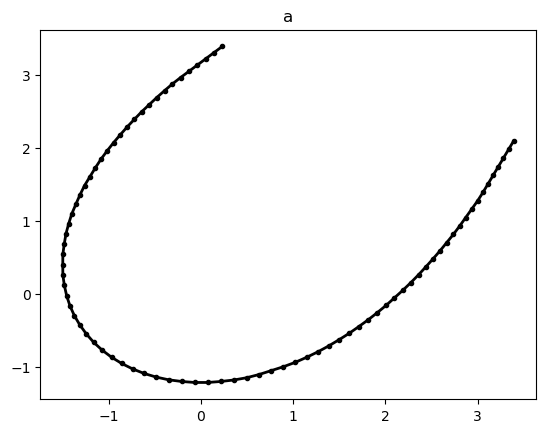

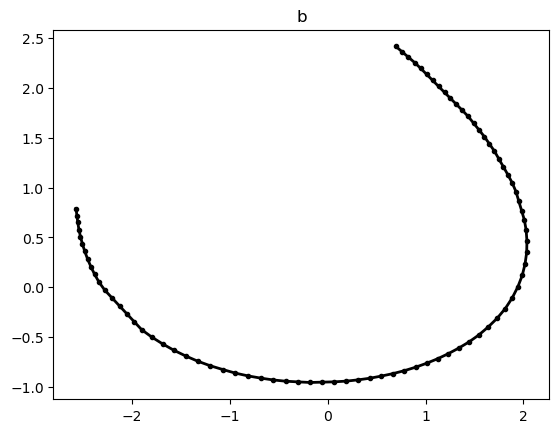

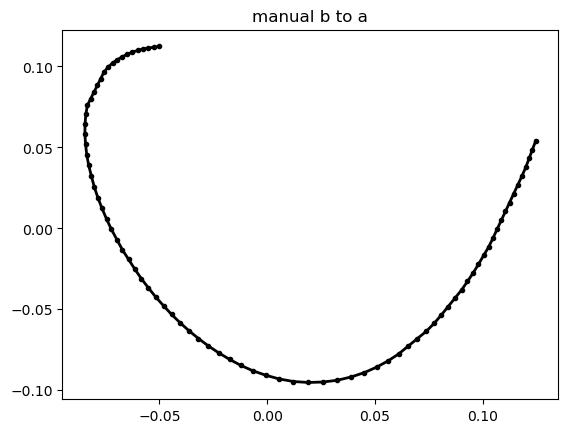

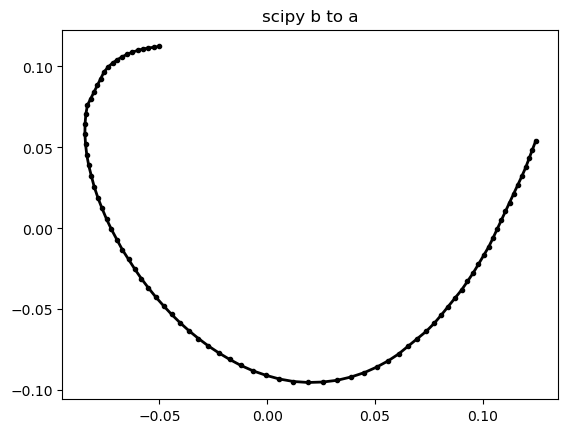

In [22]:
for x, nm in zip(
    [acurve_new, bcurve_new, res['Y_rot'], b_rotated],
    ['a', 'b', 'manual b to a', 'python b to a']
):
    plt.plot(
        x[:, 0],
        x[:, 1],
        "-o",
        linewidth=2,
        markersize=3,
        color="black"
    )   
    # sns.scatterplot(
    #     x=x[:, 0],
    #     y=x[:, 1],
    #     color="black",
    #     s=20
    # )
    plt.title(nm)
    plt.show()